<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-2--online-ad-clicks/03_statistical_hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Statistical hypothesis testing

Many ordinary people are forced to make hard choices every day. This is especially
true of jurors in the American justice system. Jurors preside over a defendant’s fate
during a trial. 

They consider the evidence and then decide between two competing
hypotheses:

* The defendant is innocent.
* The defendant is guilty.

The two hypotheses are not weighted equally: the defendant is presumed to be
innocent until proven guilty. Thus, the jurors assume that the innocence hypothesis
is true. They can only reject the innocence hypothesis if the prosecution’s evidence
is convincing. Yet the evidence is rarely 100% conclusive, and some doubt of
the defendant’s guilt remains. That doubt is factored into the legal process.

The jury is instructed to accept the innocence hypothesis if there is “reasonable doubt” of the defendant’s guilt. They can only reject the innocence hypothesis if the defendant
appears guilty “beyond a reasonable doubt.”

Reasonable doubt is an abstract concept that’s hard to define precisely. Nonetheless,
we can distinguish between reasonable and unreasonable doubt across a range of
real-world scenarios.

In our scenarios, the jurors are carrying out a statistical hypothesis test. Such tests
allow statisticians to choose between two competing hypotheses, both of which arise
from uncertain data. One of the hypotheses is accepted or rejected based on a measured
level of doubt.

In this notebook, we explore several well-known statistical hypothesis
testing techniques. We begin with a simple test to measure whether a sample mean
noticeably deviates from an existing population.

##Setup

In [1]:
from collections import defaultdict
import itertools

import numpy as np
from scipy import stats
import math

import matplotlib.pyplot as plt

In [2]:
# Penalizing centers using the squared distance from the minimum
def squared_distance(value1, value2):
  return (value1 - value2) ** 2

In [3]:
# Penalizing centers using the total sum of squared distances
def sum_of_squared_distances(value, measurements):
  return sum(squared_distance(value, m) for m in measurements)

In [4]:
# Computing California’s sum of squares
def sum_of_squares(data):
  mean = np.mean(data)
  return sum(squared_distance(value, mean) for value in data)

In [5]:
# Computing the variance from mean squared distance
def variance(data):
  mean = np.mean(data)
  return np.mean([squared_distance(value, mean) for value in data])

In [6]:
# Computing the weighted variance using np.average
def weighted_variance(data, weights):
  mean = np.average(data, weights=weights)
  squared_distances = [squared_distance(value, mean) for value in data]
  return np.average(squared_distances, weights=weights)

assert weighted_variance([75, 77], [9, 1]) == np.var(9 * [75] + [77])

##Divergence between sample and population mean

Now, let’s
imagine a scenario where we analyze every fifth-grade classroom in North Dakota.
One spring day, all fifth graders in the state are given the same assessment exam. The
exam grades are fed into North Dakota’s assessment database, and the population
mean and variance are computed across all grades in the state. According to the
records, the population mean is 80, and the population variance is 100.

In [7]:
# Population mean and variance of North Dakota grades
population_mean = 80
population_variance = 100

Let’s temporarily assume that the null hypothesis is true and both Dakotas share
the same population mean and variance.

In [8]:
# Normal curve parameters if the null hypothesis is true
mean = population_mean
sem = (population_variance / 18) ** 0.5

If the null hypothesis is true, the probability of encountering an average exam grade
of at least 84% is equal to `stats.norm.sf(84 mean, sem)`. 

Let’s check that probability.

In [9]:
# Finding the probability of a high-performance grade
prob_high_grade = stats.norm.sf(84, mean, sem)
print(f"Probability of an average grade >= 84 is {prob_high_grade}")

Probability of an average grade >= 84 is 0.044843010885182284


We will now compute the probability of observing an exam average that’s less than
or equal to 76%.

The calculation can be carried out with SciPy’s `stats.norm.cdf`
method, which computes the cumulative distribution function of the normal curve.

A cumulative distribution function is the direct opposite of the survival function.

We now use `stats.norm.cdf` to find the probability of observing an unusually low average grade.

In [10]:
# Finding the probability of a low-performance grade
prob_low_grade = stats.norm.cdf(76, mean, sem)
print(f"Probability of an average grade <= 76 is {prob_low_grade}")

Probability of an average grade <= 76 is 0.044843010885182284


It appears that `prob_low_grade` is equal to `prob_high_grade`. This equality arises
from the symmetric shape of the normal curve. 

The cumulative distribution and the
survival function are mirror images that are reflected across the mean. 

Thus,
`stats.norm.sf(mean + x, mean, sem)` always equals `stats.norm.cdf(mean - x, mean, sem)` for any input x. 

Next, we visualize both functions to confirm their reflection
across a vertically plotted mean.

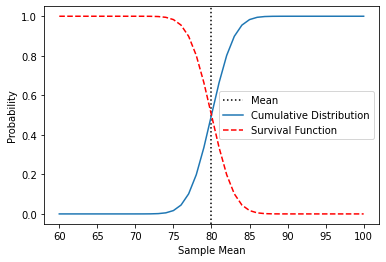

In [11]:
# Comparing the survival and cumulative distribution functions
for x in range(-100, 100):
  sf_value = stats.norm.sf(mean + x, mean, sem)
  assert sf_value == stats.norm.cdf(mean - x, mean, sem)

plt.axvline(mean, color="k", label="Mean", linestyle=":")
x_values = range(60, 101)
plt.plot(x_values, stats.norm.cdf(x_values, mean, sem), label="Cumulative Distribution")
plt.plot(x_values, stats.norm.sf(x_values, mean, sem), label="Survival Function", color="r", linestyle="--")
plt.legend()
plt.xlabel("Sample Mean")
plt.ylabel("Probability")
plt.show()

Now we are ready to sum `prob_high_grade` and `prob_low_grade`. Due to symmetry, that sum equals `2 * prob_high_grade`.

Conceptually, the sum represents the probability
of observing an extreme deviation from the population mean when the null hypothesis
is true. Statisticians refer to this null-hypothesis-driven probability as the `p-value`.

In [12]:
# Computing the null-hypothesis-driven p-value
p_value = prob_low_grade + prob_high_grade
assert p_value == 2 * prob_high_grade

print(f"The p-value is {p_value}")

The p-value is 0.08968602177036457


Under the null hypothesis, there is approximately a 9% chance of observing the grade
extreme at random. 

It’s therefore plausible that the null hypothesis is true and the
extreme test average is just a random fluctuation.

Let’s check if that slight grade shift would have influenced our p-value.

In [13]:
# Computing the p-value for an adjusted sample mean
def compute_p_value(observed_mean, population_mean, sem):
  mean_diff = abs(population_mean - observed_mean)
  prob_high = stats.norm.sf(population_mean + mean_diff, population_mean, sem)
  return 2 * prob_high

In [14]:
new_p_value = compute_p_value(85, mean, sem)
print(f"The updated p-value is {new_p_value}")

The updated p-value is 0.03389485352468927


A tiny increase in the average grade has caused a threefold decrease in the p-value.

Now,
under the null hypothesis, there’s only a 3.3% chance of observing an average test grade
that’s at least as extreme as 85%. This likelihood is low, and we might therefore be
tempted to reject the null hypothesis.

This is not an easy question to answer. Generally, statisticians tend to reject the null
hypothesis if the p-value is less than or equal to 0.05. The threshold of 0.05 is called
the significance level, and p-values below that threshold are deemed to be statistically significant.

Unfortunately, the threshold of 0.05 doesn’t actually arise from the laws of mathematics
and statistics: it’s an ad hoc value chosen by the academic community as a requirement
for research publication.

As a consequence, many research journals are flooded
with type I errors. A type I error is defined as an erroneous rejection of the null hypothesis.
Such errors occur when random data fluctuations are interpreted as genuine
deviations from the population mean.

But there is currently no consensus on whether using a lower threshold
is appropriate, since doing so would lead to an increase in type II errors, in which we
wrongly reject the alternative hypothesis.

Selecting an optimal significance level is difficult. Nevertheless, let’s temporarily
set the significance level to a very stringent value of 0.001.

In [15]:
# Scanning for a stringent p-value result
for grade in range(80, 100):
  p_value = compute_p_value(grade, mean, sem)
  if p_value < 0.001:
    break

print(f"An average grade of {grade} leads to a p-value of {p_value}")

An average grade of 88 leads to a p-value of 0.0006885138966450773


Given the new threshold, we would require an average grade of at least 88% to reject
the null hypothesis. Thus, an average grade of 87% would not be considered statistically
significant, even though it’s noticeably higher than the population mean.

Our
lowering of the cutoff has inevitably exposed us to an increased risk of type II errors.

But we also proceed with excessive caution to avoid erroneously rejecting the
null hypothesis. 

In particular, we do our best to minimize the most common cause of
type I errors and the topic of the next subsection: **data dredging**.

##Data dredging

In [16]:
# Randomly sampling Montana’s exam performance
np.random.seed(0)

random_average_grade = np.random.normal(mean, sem)
print(f"Average grade equals {random_average_grade:.2f}")

Average grade equals 84.16


In [17]:
# Testing the significance of Montana’s exam performance
if compute_p_value(random_average_grade, mean , sem) <= 0.05:
  print("The observed result is statistically significant")
else:
  print("The observed result is not statistically significant")

The observed result is not statistically significant


In [18]:
# Randomly searching for a significant state result
np.random.seed(0)

for i in range(1, 49):
  print(f"We visited state {i + 1}")
  random_average_grade = np.random.normal(mean, sem)
  p_value = compute_p_value(random_average_grade, mean , sem)
  if p_value <= 0.05:
    print("We found a statistically significant result.")
    print(f"The average grade was {random_average_grade:.2f}")
    print(f"The p-value was {p_value}")
    break

if i == 48:
  print("We visited every state and found no significant results.")

We visited state 2
We visited state 3
We visited state 4
We visited state 5
We found a statistically significant result.
The average grade was 85.28
The p-value was 0.025032993883401307


In [19]:
# Using the Bonferroni correction to adjust significance
num_planned_experiments = 49
significance_level = .5 / num_planned_experiments

In [20]:
# Rerunning an analysis using an adjusted significance level
np.random.seed(0)

for i in range(1, 49):
  print(f"We visited state {i + 1}")
  random_average_grade = np.random.normal(mean, sem)
  p_value = compute_p_value(random_average_grade, mean , sem)
  if p_value <= significance_level:
    print("We found a statistically significant result.")
    print(f"The average grade was {random_average_grade:.2f}")
    print(f"The p-value was {p_value}")
    break

if i == 48:
  print("We visited every state and found no significant results.")

We visited state 2
We visited state 3
We visited state 4
We visited state 5
We visited state 6
We visited state 7
We visited state 8
We visited state 9
We visited state 10
We visited state 11
We visited state 12
We visited state 13
We visited state 14
We visited state 15
We visited state 16
We visited state 17
We visited state 18
We visited state 19
We visited state 20
We visited state 21
We visited state 22
We visited state 23
We visited state 24
We visited state 25
We visited state 26
We visited state 27
We visited state 28
We visited state 29
We visited state 30
We visited state 31
We visited state 32
We visited state 33
We visited state 34
We visited state 35
We visited state 36
We visited state 37
We visited state 38
We visited state 39
We visited state 40
We visited state 41
We visited state 42
We visited state 43
We visited state 44
We visited state 45
We visited state 46
We visited state 47
We visited state 48
We visited state 49
We visited every state and found no significant 

##Bootstrapping with replacement

Consider the following scenario, in which we own a very large aquarium. It holds 20
tropical fish of lengths varying from 2 cm to nearly 120 cm. The average fish length
equals 27 cm.

In [22]:
# Defining lengths of fish in an aquarium
fish_lengths = np.array([46.7, 17.1, 2.0, 19.2, 7.9, 15.0, 43.4, 8.8, 47.8, 19.5, 2.9, 53.0, 23.5, 118.5, 3.8, 2.9, 53.9, 23.9, 2.0, 28.2])
assert fish_lengths.mean() == 27

In [24]:
# Sampling a random fish from the aquarium
np.random.seed(0)

random_fish_length = np.random.choice(fish_lengths, size=1)[0]
sampled_fish_lengths = [random_fish_length]
print(sampled_fish_lengths)

[23.5]


In [25]:
# Sampling 20 random fish with repetition
np.random.seed(0)

for _ in range(20):
  random_fish_length = np.random.choice(fish_lengths, size=1)[0]
  sampled_fish_lengths.append(random_fish_length)
print(sampled_fish_lengths)

[23.5, 23.5, 2.9, 46.7, 19.2, 19.2, 8.8, 19.5, 28.2, 2.0, 7.9, 43.4, 23.5, 17.1, 43.4, 8.8, 3.8, 23.9, 15.0, 118.5, 47.8]


In [26]:
# Comparing the sample mean to the aquarium mean
sample_mean = np.mean(sampled_fish_lengths)
print(f"Mean of sampled fish lengths is {sample_mean:.2f} cm.")

Mean of sampled fish lengths is 26.03 cm.


In [27]:
# Sampling with replacement using NumPy
np.random.seed(0)

new_sampled_fish_lengths = np.random.choice(fish_lengths, size=20, replace=True)

new_sample_mean = new_sampled_fish_lengths.mean()
print(f"Mean of the new sampled fish lengths is {new_sample_mean:.2f} cm.")

Mean of the new sampled fish lengths is 26.16 cm.


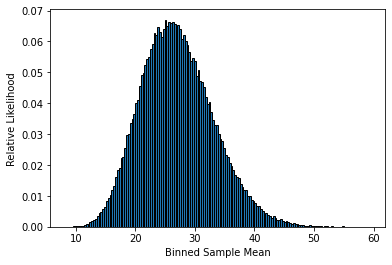

In [28]:
# Plotting the distribution of 150,000 sampled means
np.random.seed(0)

sample_means = [np.random.choice(fish_lengths, size=20, replace=True).mean() for _ in range(150000)]

likelihoods, bin_edges, _ = plt.hist(sample_means, bins="auto", edgecolor="black", density=True)
plt.xlabel("Binned Sample Mean")
plt.ylabel("Relative Likelihood")
plt.show()

In [29]:
# Computing the skew of an asymmetric distribution
assert abs(stats.skew(sample_means)) > 0.4